<a href="https://colab.research.google.com/github/GerardoLopezO/Auto-GPT/blob/master/copia_6_enfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PIA Inteligencia Artificial
Facultad de Ingeniería Mecánica UANL

Carrera IB

**Gerardo López Oseguera**   
     Matricula: 1143867


## Importar librerias 

In [1]:
# Instalar  openyxl para leer archivos  xlsx files
!pip install openpyxl

import numpy as np 
import pandas as pd 
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## Modelo reconocimiento de imagenes 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
##para preparar imagenes  ya que el modelos solo acepta  imagens 224x224 de tamaño
img_size = 224

## Importar datos desde Kaggle 

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes


In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # Establece los permisos del archivo

kaggle.json


In [5]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k/full_df.csv

100% 1.62G/1.62G [00:16<00:00, 42.4MB/s]
100% 1.62G/1.62G [00:16<00:00, 104MB/s] 


In [6]:
!unzip ocular-disease-recognition-odir5k.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
 

## Importar datos de descripción de la imagen

In [7]:
df_data = pd.read_csv("/content/full_df.csv")
df_data.head()


ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

### Mapa de enfermedades oculares

* Normal (N),
* Diabetes (D),
* Glaucoma (G),
* Catarata (C),
* Degeneración macular asociada a la edad (A),
* Hipertensión (H),
* Miopía patológica (M),
* Otras enfermedades/anomalías (O)



```
# Tiene formato de código
```

**Análisis de los datos**

Un problema con estos  datos es que tiene imágenes  para el ojo izquierdo como para el derecho en archivos separados,  que es lo que mormalmente todos los dispositivos lo archivan de esta manera. Pero para hacer el diagnóstico codificado numéricamente (las columnas etiquetadas como C, D, G...) no se especifica el ojo izquierdo o derecho.
La lógica es que si hubiera algún ojo con un problema, entonces se obtendría un "verdadero" o "1". El '1' no nos dice si se trata del ojo izquierdo o derecho, y en algunas consultas esto no importa, pero cuando sacamos nuestros archivos de imagen, esto se convierte en un problema.


Tenemos que basarnos en los datos del diagnóstico por palabras clave, si hay un "1" o un "2".

Vemos en el diganostico codificaco vamos a seleccionar todos los 1  de C o "cataratas"


In [8]:
df_data[df_data.C==1].head()

ID  Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
0     0           69      Female    0_left.jpg    0_right.jpg   
20   24           75      Female   24_left.jpg   24_right.jpg   
65   81           66        Male   81_left.jpg   81_right.jpg   
86  103           55      Female  103_left.jpg  103_right.jpg   
93  112           57      Female  112_left.jpg  112_right.jpg   

                           Left-Diagnostic Keywords  \
0                                          cataract   
20                                    normal fundus   
65  moderate non proliferative retinopathy，cataract   
86                                         cataract   
93                                    normal fundus   

                          Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                                     normal fundus  0  0  0  1  0  0  0  0   
20                                         cataract  0  0  0  1  0  0  0  0   
65  moderate non proliferative retinopathy，cataract  0  1  0  1  0  0  0  0   
86                                    normal fundus  0  0  0  1  0  0  0  0   
93                                         cataract  0  0  0  1  0  0  0  0   

                                             filepath labels  \
0   ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
20  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
65  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
86  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
93  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   

                      target       filename  
0   [1, 0, 0, 0, 0, 0, 0, 0]    0_right.jpg  
20  [0, 0, 0, 1, 0, 0, 0, 0]   24_right.jpg  
65  [0, 1, 0, 0, 0, 0, 0, 0]   81_right.jpg  
86  [1, 0, 0, 0, 0, 0, 0, 0]  103_right.jpg  
93  [0, 0, 0, 1, 0, 0, 0, 0]  112_right.jpg

En este caso   nos arroja todas las "cataratas" sin importar el ojo y esto es un problema ya que puede haber cataratas en los 2 ojos, esto tipo de arreglo no es muy conveniente.
  
Cuando procesemos las imagenes no nos dira que ojo y puede interpretar mal las imagenes, ya que el modelo que se utiliza  analiza ciertas zonas  y espacios y esto puede crear  confucion  para los diagnosticos.

##**Analizamos el contenido del DataFrame**

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

### Encontrar el número de resultados positivos "1" en la codificacion de diagnostico.  

Vemos las columnas (seleccionamos el eje,  axis=0) y contaremos todos los '1' en ella.

In [10]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

## Problemas con las categorías codificadas

Vemos que basarse en las categorías de diagnóstico codificadas "N D G C A H M O" podía ser problemático ya que tenemos algunos "1"  tanto para ojos normales como enfermos, por el error de especificaban para qué ojo.

El problema con esto es que los archivos y el diagnóstico son específicos de la orientación y la fila de datos contiene información de ambos ojos.  Si utilizamos exclusivamente las categorías, más adelante en el analisis nos vamos a topar con el problema de que es imposible obtener datos específicos sobre la orientación del ojo, ya que se pierden en las categorías codificadas.  

Por lo que cambiaremos y daremos formato para poder identificar bien los diganosticos.

## Crear otro DataFrame
vamos a crear otro DataFrame  donde indexamos la posicion en el DataFrame  o sea que ID se vuelve el index del DataFrame y ademas solo vamos a seleccionar las primeras 7 columnas del DataFrame original 

In [11]:
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

Patient Age Patient Sex Left-Fundus Right-Fundus  \
0           69      Female  0_left.jpg  0_right.jpg   
1           57        Male  1_left.jpg  1_right.jpg   
2           42        Male  2_left.jpg  2_right.jpg   
3           53        Male  4_left.jpg  4_right.jpg   
4           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  
0                           normal fundus  
1                           normal fundus  
2  moderate non proliferative retinopathy  
3       mild nonproliferative retinopathy  
4  moderate non proliferative retinopathy

## Configurar rutas de archivos

In [12]:
img_dir = "/content/preprocessed_images"

In [13]:
# saber si las data esta bien o no 
import os

# Tu ruta de directorio
dir_path = "/content/preprocessed_images"

# Contadores para los archivos y los permisos
total_files = 0
readable_files = 0
writable_files = 0

# Recorrer todos los archivos en el directorio
for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)

    # Comprobar si el archivo existe
    if os.path.exists(file_path):
        total_files += 1

        # Comprobar si tienes permisos de lectura
        if os.access(file_path, os.R_OK):
            readable_files += 1

        # Comprobar si tienes permisos de escritura
        if os.access(file_path, os.W_OK):
            writable_files += 1

# Imprimir los resultados
print(f"Total de archivos en el directorio: {total_files}")
print(f"Archivos legibles: {readable_files}")
print(f"Archivos escribibles: {writable_files}")



Total de archivos en el directorio: 6392
Archivos legibles: 6392
Archivos escribibles: 6392


## **Arreglo de enfermedades**
Vamos ir seleccionando cada enfermedad para hacer DataFrame separados y poder unir los dos ojos con y diagnostico en uno solo data frame y poder identificar cada ojo con su problema por separado 

## Seleccionar sólo datos relacionados con Cataratas

Como no podemos confiar en las categorías codificadas  (las columnas etiquetadas como C, D, G...)", buscaremos términos en las columnas de palabras clave para cada ojo  (izquierdo y deerecho). como en el primer caso "catarata" 

In [14]:
# Palabra clave de diagnostico en  ojo izquierodo 'cataract' 

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
0             69      Female    0_left.jpg    0_right.jpg   
86            55      Female  103_left.jpg  103_right.jpg   
100           59        Male  119_left.jpg  119_right.jpg   
218           60      Female  254_left.jpg  254_right.jpg   
256           69      Female  294_left.jpg  294_right.jpg   

    Left-Diagnostic Keywords    Right-Diagnostic Keywords  
0                   cataract                normal fundus  
86                  cataract                normal fundus  
100                 cataract                       drusen  
218                 cataract  macular epiretinal membrane  
256                 cataract                normal fundus

In [15]:
## hacemos un DataFrame con ojos izquierdos con cataratas y imprimimos el numero de casos (filas)

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [16]:
# Ahora para el ojo derecho buscando cataratas  y visualizamos las primeras filas

df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

ID  Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
20    24           75      Female   24_left.jpg   24_right.jpg   
93   112           57      Female  112_left.jpg  112_right.jpg   
160  188           55      Female  188_left.jpg  188_right.jpg   
186  218           36      Female  218_left.jpg  218_right.jpg   
309  354           65        Male  354_left.jpg  354_right.jpg   

                              Left-Diagnostic Keywords  \
20                                       normal fundus   
93                                       normal fundus   
160  laser spot，severe proliferative diabetic retin...   
186                           refractive media opacity   
309                                      normal fundus   

    Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
20                   cataract  0  0  0  1  0  0  0  0   
93                   cataract  0  0  0  1  0  0  0  0   
160                  cataract  0  1  0  1  0  0  0  1   
186                  cataract  0  0  0  1  0  0  0  1   
309                  cataract  0  0  0  1  0  0  0  0   

                                              filepath labels  \
20   ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
93   ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
160  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
186  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
309  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   

                       target       filename  
20   [0, 0, 0, 1, 0, 0, 0, 0]   24_right.jpg  
93   [0, 0, 0, 1, 0, 0, 0, 0]  112_right.jpg  
160  [0, 0, 0, 1, 0, 0, 0, 0]  188_right.jpg  
186  [0, 0, 0, 1, 0, 0, 0, 0]  218_right.jpg  
309  [0, 0, 0, 1, 0, 0, 0, 0]  354_right.jpg

In [17]:
## hacemos un DataFrame con ojos derechos con cataratas y imprimimos el numero de casos (filas)

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


## Combinar datos de archivos de cataratas

Para ver, analizar y ejecutar bucles en las imágenes es mucho más conveniente tener todas las imágenes de cataratas en un DataFrame como una sola columna.  Añadiremos sólo los nombres de las imágenes en un nuevo DataFrame.

La función append() de pandas se utiliza para añadir filas de otro dataframe a un dataframe existente, devolviendo un nuevo dataframe. Aquí, se está añadiendo la serie df_rt_cat['Right-Fundus'] a la serie df_left_cat['Left-Fundus']. El argumento ignore_index=True indica que el nuevo dataframe resultante debe tener un nuevo índice en lugar de mantener los índices de los dataframes originales.


In [18]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()


<ipython-input-18-e401f10684d0>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)


0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

Podemos ver que las imágenes de la izquierda fueron las primeras y luego vamos a comprobar que los ultomos dato del DataFrame tiene las imágenes del ojo derecho.

In [19]:
df_cat_filenames.tail()

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

Sacamos el total de casos de cataratas

In [20]:
len(df_cat_filenames)

572

## Vemos ejemplos de los que hemos hecho en relacion de las imágenes 

Ahora tenemos un DataFrame de imágenes,veamos algunas.  Tenga en cuenta que cuando el archivo de imagen se lee con la función de OpenCV imread(), el orden de los colores es BGR (azul, verde, rojo) es diferentea al de una foto.  

Seleccionemos una imagen al azar de nuestro marco de datos.

(512, 512, 3)
2227_right.jpg


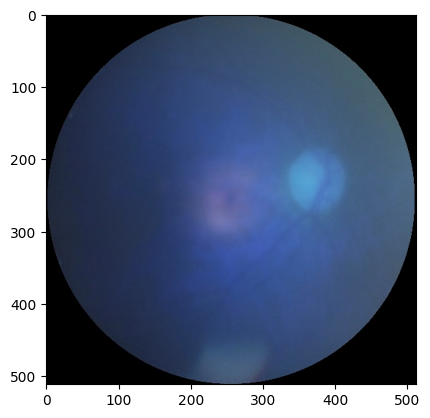

In [21]:
img = df_cat_filenames[420]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

## Muestra de imágenes

A partir de nuestro conjunto de rutas de archivos de imagen de cataratas, vamos a crear una muestra comparativa para ver el aspecto real de las cataratas.  También las convertiremos a una paleta RGB más realista.

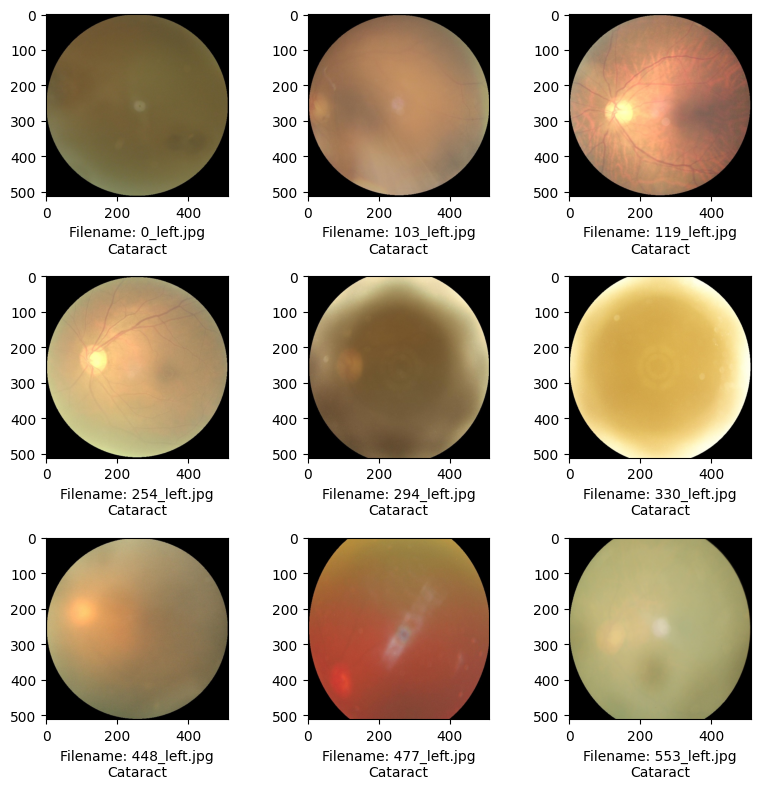

In [22]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convertir la imagen a  RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## Este código está creando subgráficos en una cuadrícula de gráficos
    ##(# filas, # de columnas, itere atravez de la cuadricula)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## etiquetamos con el nombre del archivo y el diagnostico
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout() #para mejorar la visualizacion

## Añadir etiqueta de categoría a la lista

Anteriormente creamos estos  objetos que no eran verdaderos dataframes, se convirtieron en listas después de hacer un append de columnas.  Por conveniencia, necesitamos convertirlos de nuevo en dataframes:

- df_cat_filenames

Las imágenes serán etiquetadas como cataratas, en este caso utilizaremos un generador de datos de imagen que hará la codificación de una sola vez por nosotros, para que podamos preservar las etiquetas de cadena de "palabra" reales.

In [61]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

filename     label
0    0_left.jpg  cataract
1  103_left.jpg  cataract
2  119_left.jpg  cataract
3  254_left.jpg  cataract
4  294_left.jpg  cataract

## **Arreglo de la demas enfermedades**
Ahora que tenemos el proceso seguiremos con las demas enfermedades : 
* Normal (N),
* Diabetes (D),
* Glaucoma (G),
* Catarata (C),
* Degeneración macular asociada a la edad (A),
* Hipertensión (H),
* Miopía patológica (M),
* Otras enfermedades/anomalías (O)

## Reunir las imágenes glaucoma

In [23]:
## hacemos un DataFrame con ojos izquierdo con Glaucoma y imprimimos el numero de casos (filas)

df_left_gla = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_left_gla))

262


In [24]:
## hacemos un DataFrame con ojos derechos con Glaucoma y imprimimos el numero de casos (filas)

df_rt_gla = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_rt_gla))

232


In [25]:
#combinamos los datos y lo imprimimos 

df_gla_filenames = df_left_gla['Left-Fundus'].append(df_rt_gla['Right-Fundus'], ignore_index=True)
df_gla_filenames

<ipython-input-25-fda306ec5a68>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gla_filenames = df_left_gla['Left-Fundus'].append(df_rt_gla['Right-Fundus'], ignore_index=True)


0        153_left.jpg
1        167_left.jpg
2        583_left.jpg
3       1209_left.jpg
4       1210_left.jpg
            ...      
489    1963_right.jpg
490    1967_right.jpg
491    1977_right.jpg
492    2048_right.jpg
493    2063_right.jpg
Length: 494, dtype: object

In [26]:
len(df_gla_filenames) # munero de casos de glaucoma

494

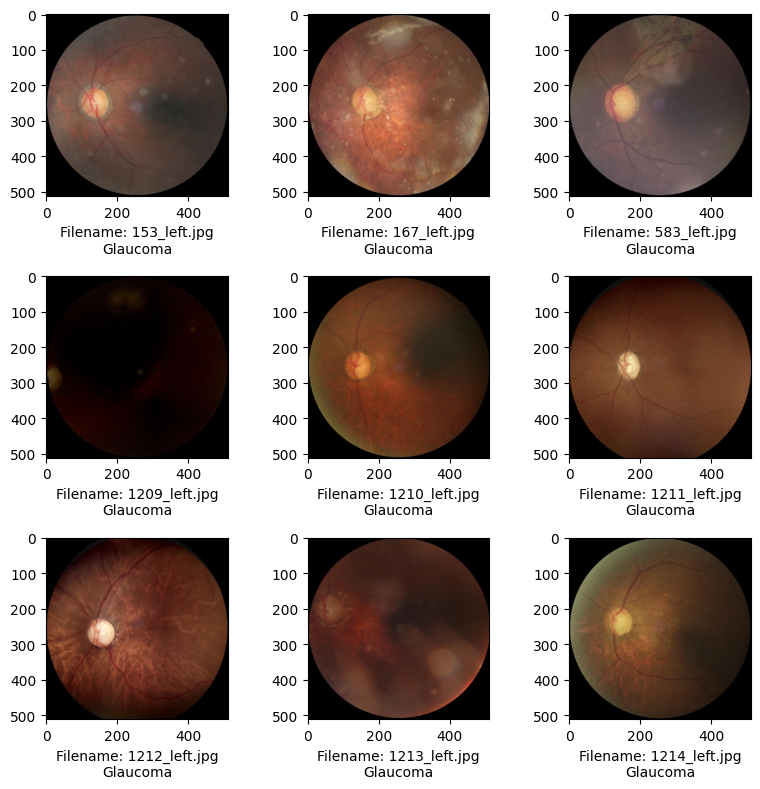

In [27]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_gla_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convertir la imagen a  RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## Este código está creando subgráficos en una cuadrícula de gráficos
    ##(# filas, # de columnas, itere atravez de la cuadricula)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## etiquetamos con el nombre del archivo y el diagnostico
    plt.xlabel('Filename: {}\n''Glaucoma'.format(df_gla_filenames[i]))

plt.tight_layout() #para mejorar la visualizacion

In [62]:
df_gla_filenames = pd.DataFrame(df_gla_filenames, columns = ["filename"])
#df_gla_filenames.set_index("filename", inplace = True)

# añade una nueva columna de '1' al dataframe
df_gla_filenames["label"] = "glaucoma"

df_gla_filenames.head()

filename     label
0   153_left.jpg  glaucoma
1   167_left.jpg  glaucoma
2   583_left.jpg  glaucoma
3  1209_left.jpg  glaucoma
4  1210_left.jpg  glaucoma

## Reunir las imágenes AMD

In [28]:
## hacemos un DataFrame con ojos izquierdo con AMD y imprimimos el numero de casos (filas)

df_left_DRY = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('dry age-related macular degeneration')]
df_left_WET = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('wet age-related macular degeneration')]
df_left_AMD = pd.concat([df_left_DRY, df_left_WET])

print(len(df_left_AMD))

255


In [29]:
## hacemos un DataFrame con ojos derechos con AMD y imprimimos el numero de casos (filas)

df_rt_DRY = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('dry age-related macular degeneration')]
df_rt_WET = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('wet age-related macular degeneration')]
df_rt_AMD = pd.concat([df_rt_DRY, df_rt_WET])

print(len(df_rt_AMD))

271


In [30]:
#combinamos los datos y lo imprimimos

df_AMD_filenames = df_left_AMD['Left-Fundus'].append(df_rt_AMD['Right-Fundus'], ignore_index=True)
df_AMD_filenames

<ipython-input-30-a722782fa12c>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_AMD_filenames = df_left_AMD['Left-Fundus'].append(df_rt_AMD['Right-Fundus'], ignore_index=True)


0         48_left.jpg
1         55_left.jpg
2        102_left.jpg
3        126_left.jpg
4        158_left.jpg
            ...      
521    1876_right.jpg
522    1880_right.jpg
523    1884_right.jpg
524    1885_right.jpg
525    1891_right.jpg
Length: 526, dtype: object

In [31]:
len(df_AMD_filenames) # munero de casos de AMD

526

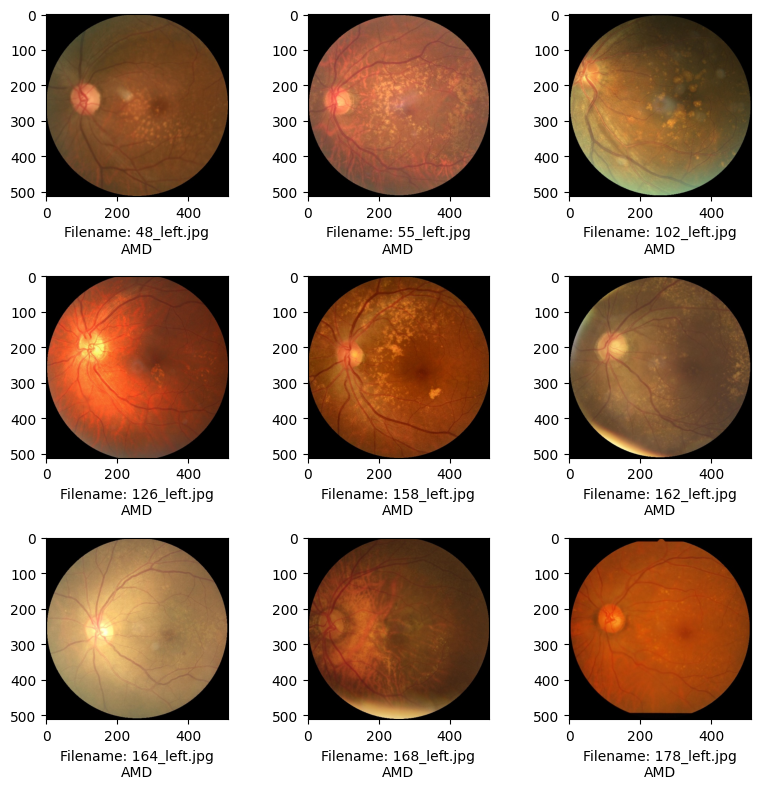

In [32]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_AMD_filenames[i]
    try:
        image = cv2.imread(os.path.join(img_dir, img))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(image_rgb)
        plt.xlabel('Filename: {}\n''AMD'.format(df_AMD_filenames[i]))
    except Exception as e:
        print(f"No se pudo procesar la imagen {img}. Error: {e}")
plt.tight_layout() #para mejorar la visualizacion


In [63]:
df_AMD_filenames = pd.DataFrame(df_AMD_filenames, columns = ["filename"])
#df_AMD_filenames.set_index("filename", inplace = True)

# añade una nueva columna de '1' al dataframe
df_AMD_filenames["label"] = "AMD"

df_AMD_filenames.head()

filename label
0   48_left.jpg   AMD
1   55_left.jpg   AMD
2  102_left.jpg   AMD
3  126_left.jpg   AMD
4  158_left.jpg   AMD

## Reunir las imágenes Diabetes

In [33]:
## hacemos un DataFrame con ojos izquierdo con retinopatia dioabetica  y imprimimos el numero de casos (filas)

df_left_mild = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('mild nonproliferative retinopathy')]
df_left_mod = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')]
df_left_snpdr = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('severe nonproliferative retinopathy')]
df_left_pdr = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('proliferative diabetic retinopathy')]
df_left_spdr = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('severe proliferative diabetic retinopathy')]
df_left_plp = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('post laser photocoagulation')]
df_left_lps = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('fundus laser photocoagulation spots')]
df_left_dbr = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('diabetic retinopathy')]
df_left_DR = pd.concat([df_left_mild, df_left_mod, df_left_snpdr, df_left_pdr, df_left_spdr, df_left_plp, df_left_lps, df_left_dbr])


print(len(df_left_DR))

1540


In [34]:
df_right_mild = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('mild nonproliferative retinopathy')]
df_right_mod = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')]
df_right_snpdr = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('severe nonproliferative retinopathy')]
df_right_pdr = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('proliferative diabetic retinopathy')]
df_right_spdr = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('severe proliferative diabetic retinopathy')]
df_right_plp = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('post laser photocoagulation')]
df_right_lps = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('fundus laser photocoagulation spots')]
df_right_dbr = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('diabetic retinopathy')]

df_rt_DR = pd.concat([df_right_mild, df_right_mod, df_right_snpdr, df_right_pdr, df_right_spdr, df_right_plp, df_right_lps, df_right_dbr])

print(len(df_rt_DR))


1606


In [35]:
#combinamos los datos y lo imprimimos

df_DR_filenames = df_left_DR['Left-Fundus'].append(df_rt_DR['Right-Fundus'], ignore_index=True)
df_DR_filenames

<ipython-input-35-273b0921cd68>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_DR_filenames = df_left_DR['Left-Fundus'].append(df_rt_DR['Right-Fundus'], ignore_index=True)


0          19_left.jpg
1          49_left.jpg
2          86_left.jpg
3         159_left.jpg
4         161_left.jpg
             ...      
3141     978_right.jpg
3142     997_right.jpg
3143    1838_right.jpg
3144    1942_right.jpg
3145    2078_right.jpg
Length: 3146, dtype: object

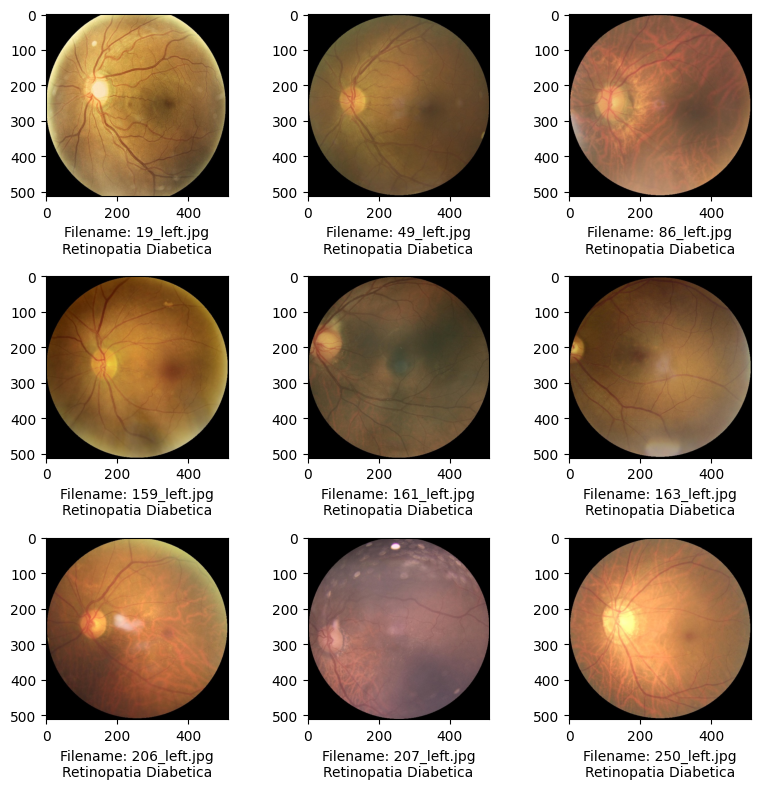

In [36]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_DR_filenames[i]
    try:
        image = cv2.imread(os.path.join(img_dir, img))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(image_rgb)
        plt.xlabel('Filename: {}\n''Retinopatia Diabetica'.format(df_DR_filenames[i]))
    except Exception as e:
        print(f"No se pudo procesar la imagen {img}. Error: {e}")
plt.tight_layout() #para mejorar la visualizacion

## Reunir imagenes de Retinopatia hipertensiva

In [37]:
## hacemos un DataFrame con ojos izquierdo con RH y imprimimos el numero de casos (filas)

df_left_rh = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('hypertensive retinopathy')]
print(len(df_left_rh))


125


In [38]:
## hacemos un DataFrame con ojos derechos con Glaucoma y imprimimos el numero de casos (filas)

df_rt_rh = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('hypertensive retinopathy')]
print(len(df_rt_rh))


130


In [39]:
#combinamos los datos y lo imprimimos 

df_RH_filenames = df_left_rh['Left-Fundus'].append(df_rt_rh['Right-Fundus'], ignore_index=True)
df_RH_filenames

<ipython-input-39-dda1cec8e663>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_RH_filenames = df_left_rh['Left-Fundus'].append(df_rt_rh['Right-Fundus'], ignore_index=True)


0         23_left.jpg
1         28_left.jpg
2         32_left.jpg
3         45_left.jpg
4         62_left.jpg
            ...      
250    4579_right.jpg
251    4581_right.jpg
252    4591_right.jpg
253    4592_right.jpg
254    4784_right.jpg
Length: 255, dtype: object

In [40]:
len(df_RH_filenames) # munero de casos de Retinopatia Hipertensiva

255

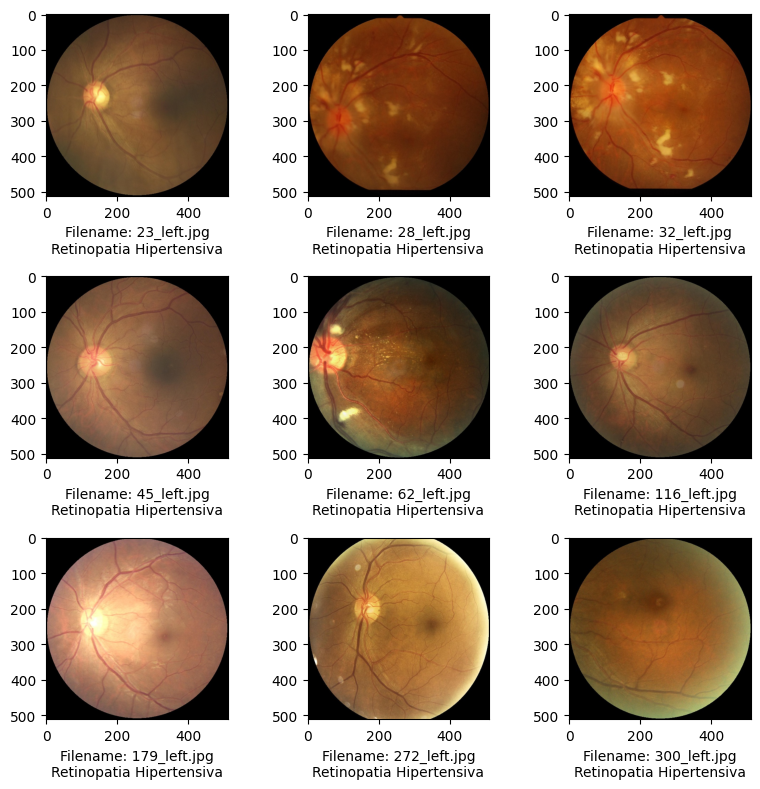

In [41]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_RH_filenames[i]
    try:
        image = cv2.imread(os.path.join(img_dir, img))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(image_rgb)
        plt.xlabel('Filename: {}\n''Retinopatia Hipertensiva'.format(df_RH_filenames[i]))
    except Exception as e:
        print(f"No se pudo procesar la imagen {img}. Error: {e}")
plt.tight_layout() #para mejorar la visualizacion

In [64]:
df_RH_filenames = pd.DataFrame(df_RH_filenames, columns = ["filename"])
#df_RH_filenames.set_index("filename", inplace = True)

# añade una nueva columna de '1' al dataframe
df_RH_filenames["label"] = "Retinopatia Hipertensiva"

df_RH_filenames.head()

filename                     label
0  23_left.jpg  Retinopatia Hipertensiva
1  28_left.jpg  Retinopatia Hipertensiva
2  32_left.jpg  Retinopatia Hipertensiva
3  45_left.jpg  Retinopatia Hipertensiva
4  62_left.jpg  Retinopatia Hipertensiva

## Reunir las Imagenes  de Miopia 

In [42]:
## hacemos un DataFrame con ojos izquierdo con Miopia y imprimimos el numero de casos (filas)

df_left_mi = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('pathological myopia')]
print(len(df_left_mi))

208


In [43]:
## hacemos un DataFrame con ojos derechos con Glaucoma y imprimimos el numero de casos (filas)

df_rt_mi = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('pathological myopia')]
print(len(df_rt_mi))

225


In [44]:
#combinamos los datos y lo imprimimos 

df_M_filenames = df_left_mi['Left-Fundus'].append(df_rt_mi['Right-Fundus'], ignore_index=True)
df_M_filenames

<ipython-input-44-e64dd101c8f7>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_M_filenames = df_left_mi['Left-Fundus'].append(df_rt_mi['Right-Fundus'], ignore_index=True)


0         13_left.jpg
1         18_left.jpg
2         35_left.jpg
3        106_left.jpg
4        144_left.jpg
            ...      
428    1666_right.jpg
429    1673_right.jpg
430    1681_right.jpg
431    1686_right.jpg
432    1694_right.jpg
Length: 433, dtype: object

In [45]:
len(df_M_filenames) # munero de casos de Miopia

433

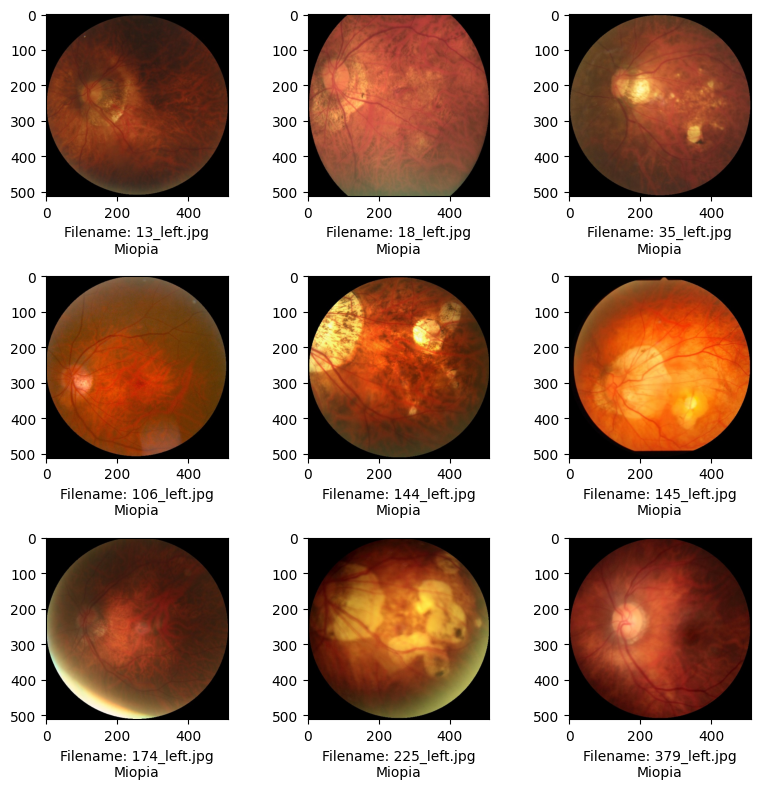

In [46]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_M_filenames[i]
    try:
        image = cv2.imread(os.path.join(img_dir, img))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(image_rgb)
        plt.xlabel('Filename: {}\n''Miopia'.format(df_M_filenames[i]))
    except Exception as e:
        print(f"No se pudo procesar la imagen {img}. Error: {e}")
plt.tight_layout() #para mejorar la visualizacion

In [65]:
df_M_filenames = pd.DataFrame(df_M_filenames, columns = ["filename"])
#df_M_filenames.set_index("filename", inplace = True)

# añade una nueva columna de '1' al dataframe
df_M_filenames["label"] = "Miopia patologica"

df_M_filenames.head()

filename              label
0   13_left.jpg  Miopia patologica
1   18_left.jpg  Miopia patologica
2   35_left.jpg  Miopia patologica
3  106_left.jpg  Miopia patologica
4  144_left.jpg  Miopia patologica

## Reunir las imágenes normales
Ahora tenemos que reunir un conjunto de imágenes normales.  Primero vamos a ver cuántas imágenes normales tenemos disponibles - ya lo hicimos antes pero vamos a echar un vistazo de nuevo.  Recordemos que estamos trabajando con dos ojos y que hemos observado que algunas de las columnas codificadas no tienen datos para ambos ojos, por lo que no se cuenta realmente toda la historia.  Tenemos que mirar el etiquetado en las palabras clave, ya que parece ser la fuente de la verdad cuando se consideran ambos ojos.

In [47]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

Vemos 2101 resultados codificados como "normal", pero no podemos fiarnos mucho, ya que es posible que no se tengan en cuenta los dos ojos.  Veamos los resultados de palabras clave que contienen "normal", por separado para ambos ojos:

In [48]:
df_data2.head()

Patient Age Patient Sex Left-Fundus Right-Fundus  \
0           69      Female  0_left.jpg  0_right.jpg   
1           57        Male  1_left.jpg  1_right.jpg   
2           42        Male  2_left.jpg  2_right.jpg   
3           53        Male  4_left.jpg  4_right.jpg   
4           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  
0                           normal fundus  
1                           normal fundus  
2  moderate non proliferative retinopathy  
3       mild nonproliferative retinopathy  
4  moderate non proliferative retinopathy

In [49]:
## hacemos un DataFrame con ojos izquierdo con normales y imprimimos el numero de casos (filas)

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [50]:
### hacemos un DataFrame con ojos derecho con normales y imprimimos el numero de casos (filas)

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


Por tanto, si sumamos todas estas imágenes, tenemos más de 5.000 imágenes (tanto del ojo izquierdo como del derecho) que se consideran "normales".  Esto es mucho más de lo que tenemos para nuestros datos de "cataratas", que sólo tenían 572 imágenes.  Así que, en ese caso, vamos a seleccionar al azar la misma cantidad de imágenes "normales".

In [51]:
#combinamos los datos y lo imprimimos 
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

<ipython-input-51-e0f3cfea549b>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)


0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

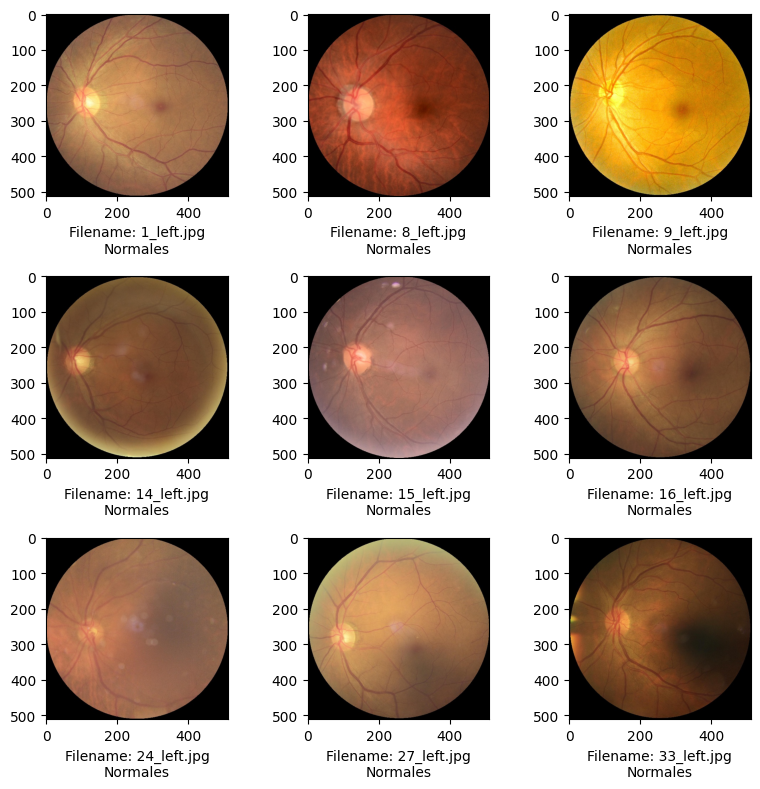

In [52]:
plt.figure(figsize=(8,8)) #tamaño de las imagenes
for i in range(9):
    img = df_norm_filenames[i]
    try:
        image = cv2.imread(os.path.join(img_dir, img))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(image_rgb)
        plt.xlabel('Filename: {}\n''Normales'.format(df_norm_filenames[i]))
    except Exception as e:
        print(f"No se pudo procesar la imagen {img}. Error: {e}")
plt.tight_layout() #para mejorar la visualizacion

## Problema de Muestras 
El desequilibrio de clases,  puede ser un problema en el aprendizaje automático. En este caso, el modelo podría ser sesgado hacia las clases que tienen más ejemplos (en este caso, "Normal" y "Diabetes"), y podría no aprender a clasificar bien las clases con menos ejemplos.

Hay varias estrategias para manejar el desequilibrio de clases:

- **Submuestreo de la mayoría**: Esta estrategia implica eliminar aleatoriamente ejemplos de las clases de mayoría hasta que el número de ejemplos en cada clase sea más equilibrado. Sin embargo, esto puede llevar a la pérdida de información potencialmente útil.

- **Sobremuestreo de la minoría**: Esta estrategia implica duplicar aleatoriamente ejemplos de las clases minoritarias hasta que el número de ejemplos en cada clase sea más equilibrado. Esto puede ayudar a mejorar el rendimiento del modelo en las clases minoritarias, pero también puede llevar a un sobreajuste si los mismos ejemplos se duplican muchas veces.

- **Generar nuevas muestras**: Podrías generar nuevas muestras en las clases minoritarias utilizando técnicas como la ampliación de datos (por ejemplo, rotar, cambiar la escala, recortar, o cambiar el brillo de las imágenes), o SMOTE (Synthetic Minority Over-sampling Technique), que crea "sintéticamente" ejemplos de las clases minoritarias en el espacio de características.

- **Uso de métricas de evaluación apropiadas**: En lugar de usar precisión, que puede ser engañosa en conjuntos de datos desequilibrados, podrías usar métricas como la curva ROC AUC, la precisión promedio, el F1-score, etc. que tienen en cuenta tanto los falsos positivos como los falsos negativos.

- **Entrenamiento con pesos de clase**: Algunos algoritmos de aprendizaje automático permiten asignar pesos a las clases, lo que puede ser útil para el entrenamiento en datos desequilibrados. Por ejemplo, podrías dar más peso a las clases minoritarias y menos peso a las clases mayoritarias



## En nuestro caso haremos un submuestreo de la mayoria 

disminuiremos normales y diabetes a 572


## Seleccionar y crear un conjunto aleatorio de los ojos normales 

In [53]:
##elegimos 572 para igualar el número de imágenes de cataratas que sacamos

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## el índice estáen desorden  y hay que ordenarlo 

5577    4583_right.jpg
2924     351_right.jpg
3349    2556_right.jpg
2692     3407_left.jpg
1848     2484_left.jpg
dtype: object

In [54]:
## también restableceremos el índice
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0      4583_right.jpg
1       351_right.jpg
2      2556_right.jpg
3       3407_left.jpg
4       2484_left.jpg
            ...      
567    2401_right.jpg
568    3178_right.jpg
569    3401_right.jpg
570     1035_left.jpg
571    3313_right.jpg
Length: 572, dtype: object

## Crear una muestra de imágenes "normales"

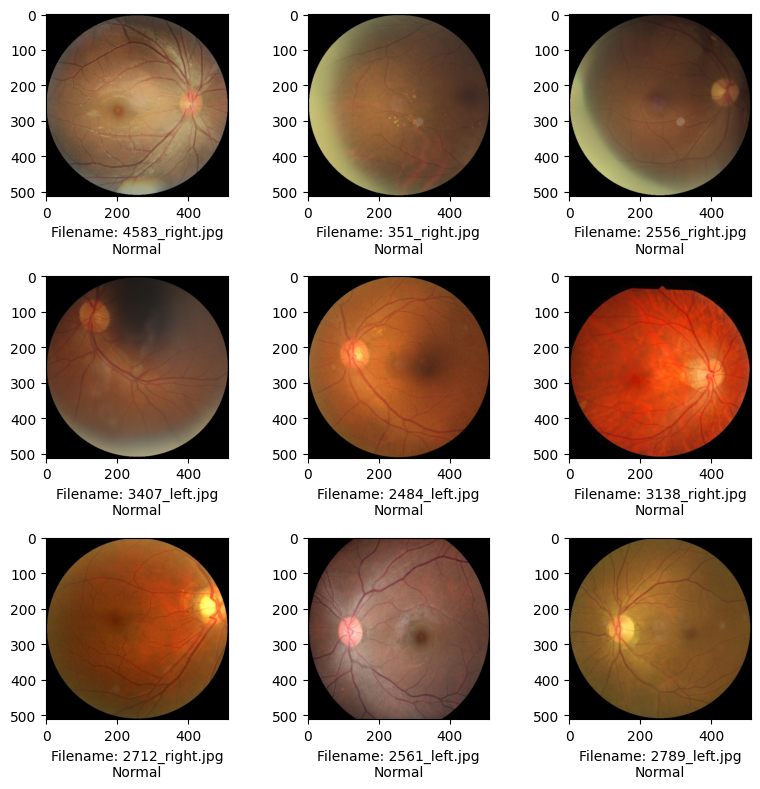

In [55]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout()

In [66]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# añade una nueva columna de '1' al dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

filename   label
0  4583_right.jpg  normal
1   351_right.jpg  normal
2  2556_right.jpg  normal
3   3407_left.jpg  normal
4   2484_left.jpg  normal

## Seleccionar y crear un conjunto aleatorio de los ojos con Retinopatia Diabetica  

In [58]:
##elegimos 572 para igualar el número de imágenes de retinopati diabetica  que sacamos

df_DR_filenames_random = df_DR_filenames.sample(n = 572)
df_DR_filenames_random.head()

## el índice estáen desorden  y hay que ordenarlo 

741     4221_left.jpg
1389    4504_left.jpg
1394    4558_left.jpg
1245    4421_left.jpg
85      4083_left.jpg
dtype: object

In [59]:
## también restableceremos el índice
df_DR_filenames_random = df_DR_filenames_random.reset_index(drop=True)
df_DR_filenames_random

0       4221_left.jpg
1       4504_left.jpg
2       4558_left.jpg
3       4421_left.jpg
4       4083_left.jpg
            ...      
567      311_left.jpg
568     4138_left.jpg
569    1138_right.jpg
570     874_right.jpg
571    4484_right.jpg
Length: 572, dtype: object

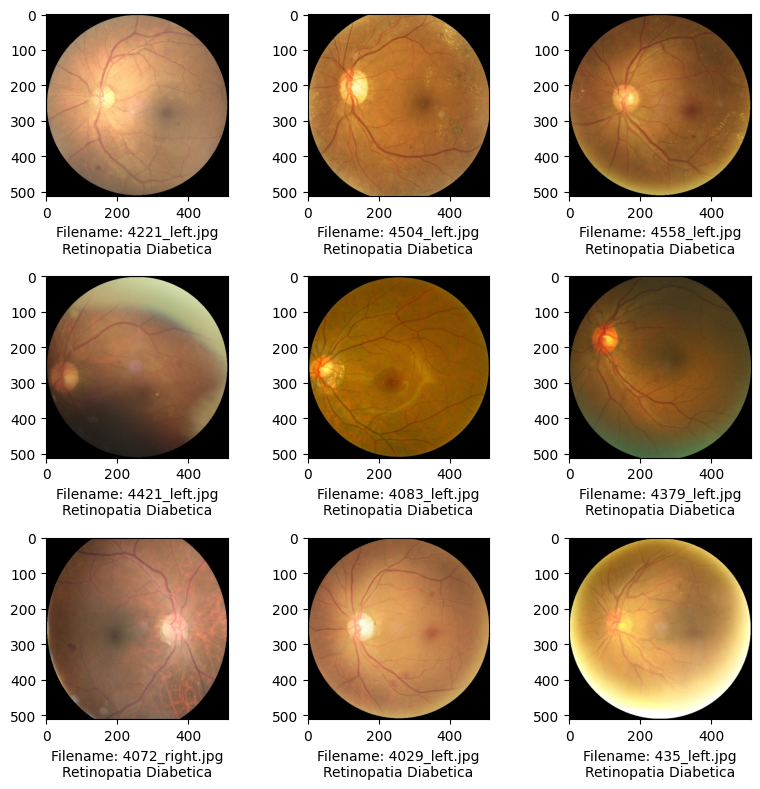

In [60]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_DR_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Retinopatia Diabetica'.format(df_DR_filenames_random[i]))

plt.tight_layout()

In [68]:
df_DR_filenames_random = pd.DataFrame(df_DR_filenames_random, columns = ["filename"])
#df_DR_filenames.set_index("filename", inplace = True)

# añade una nueva columna de '1' al dataframe
df_DR_filenames_random["label"] = "Retinopatia Diabetica"

df_DR_filenames_random.head()

filename                  label
0  4221_left.jpg  Retinopatia Diabetica
1  4504_left.jpg  Retinopatia Diabetica
2  4558_left.jpg  Retinopatia Diabetica
3  4421_left.jpg  Retinopatia Diabetica
4  4083_left.jpg  Retinopatia Diabetica

## Combinar el DataFrame en un único conjunto de datos

Tenemos DataFrame de cataratas,glaucoma,AMD, Retinopatia Hipertensiva, Miopia Patologica, Retinopatia Diabetica y normales con etiquetas, necesitamos combinarlos para formar un único DataFrame para alimentar nuestro generador de imágenes.


In [69]:
df_combined = df_DR_filenames_random.append([
    df_norm_filenames_random, 
    df_M_filenames,  
    df_RH_filenames, 
    df_AMD_filenames, 
    df_gla_filenames, 
    df_cat_filenames
], ignore_index=True)

df_combined

<ipython-input-69-c0ad57c46cb2>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_DR_filenames_random.append([


filename                  label
0      4221_left.jpg  Retinopatia Diabetica
1      4504_left.jpg  Retinopatia Diabetica
2      4558_left.jpg  Retinopatia Diabetica
3      4421_left.jpg  Retinopatia Diabetica
4      4083_left.jpg  Retinopatia Diabetica
...              ...                    ...
3419  2243_right.jpg               cataract
3420  2246_right.jpg               cataract
3421  2247_right.jpg               cataract
3422  2248_right.jpg               cataract
3423  2282_right.jpg               cataract

[3424 rows x 2 columns]

## Aleatorizar nuestro DataFrame combinado final

Antes de alimentar este conjunto organizado de imágenes, necesitamos aleatorizar las filas que contiene para que cuando entrenemos lo hagamos a partir de un conjunto aleatorio de muestras.

Si añadimos un índice, acabaremos añadiendo una columna para los valores del índice antiguo, por lo que no queremos nuevas columnas, así que eliminaremos el índice antiguo y permitiremos que el nuevo DataFrame tenga uno nuevo.

In [70]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

filename                     label
0      723_right.jpg  Retinopatia Hipertensiva
1      955_right.jpg                  cataract
2      2248_left.jpg                  cataract
3     2843_right.jpg                    normal
4     1868_right.jpg                       AMD
...              ...                       ...
3419   411_right.jpg     Retinopatia Diabetica
3420    594_left.jpg                  cataract
3421   158_right.jpg                       AMD
3422   1885_left.jpg                       AMD
3423   1301_left.jpg                  glaucoma

[3424 rows x 2 columns]

## Dividir nuestro dataframe en test, train, validation dataframes

Dado que vamos a seguir utilizando un DataFrame con una columna de etiquetas, no podemos utilizar la función común de sklearn test-train-split. en su lugar, simplificaremos las cosas y crearemos tres marcos de datos extrayendo muestras aleatorias y luego excluyendo esas muestras de otro conjunto utilizando el método drop.

In [71]:
# Extraer el 80% del DataFrame combinados y reservarlo para los datos de entrenamiento.
# el generador de datos creará automáticamente un conjunto de validación para nosotros más tarde

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# excluir el 80% ya elegido, el 20% restante se destinará a pruebas
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

3424
2739
685


## Generador  de imágenes a partir del Dataset
Tenemos un bonito dataframe que hemos creado y Keras combinado con esta práctica función nos permitirá generar imágenes aumentadas y escaladas con el mínimo esfuerzo.  

Aquí añadiremos algunos parámetros que realizarán algunos ajustes a las imágenes.

In [72]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## para las pruebas no queremos hacer demasiado aumento, sólo lo escalaremos.

test_datagen=ImageDataGenerator(rescale=1./255.)

## Convertir las filas de objetos a cadenas

Aunque el flujo desde dataframe funcionará con otros tipos de datos, seguía obteniendo errores que solicitaban convertir las filas del dataframe a tipo string.

In [73]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

## Crear generadores de imágenes de prueba, entrenamiento y validación

In [74]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## el conjunto de validación se crea a partir del conjunto de entrenamiento, 
## lo fijamos en el 20% de los datos de entrenamiento en la codigo anterior

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 2191 validated image filenames belonging to 7 classes.
Found 547 validated image filenames belonging to 7 classes.
Found 685 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## Resultados del generador de imágenes

Veamos los datos reales que se crean a partir del generador de imágenes.  El comando "next" divide los datos del generador en dos matrices numpy - una con los datos de la imagen y otra con los datos de la etiqueta.

data.shape devuelve las dimensiones del tensor 
- 32 es el numero de imagenes en el lote
- 224 x 244 son las dimensiones de las imagenes
- 3 es el numero de color (rojo, verde y azul)

In [75]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

Aquiveremos un vector one-hot que es un vector deonde todos los elementos son 0, excepto uno que es 1. . El índice del elemento 1 en el vector indica la categoría a la que pertenece la imagen. Por ejemplo, si tienes 7 categorías, y train_labels[0] es [0, 0, 1, 0, 0, 0, 0], entonces la primera imagen en el lote

In [76]:
train_labels[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

## Checamos como son nustras imagenes agumentadas

este un método de interpolación usado para decidir cómo rellenar los pixeles cuando la imagen se redimensiona o se transforma de alguna manera. En este caso, se usa el valor del pixel más cercano

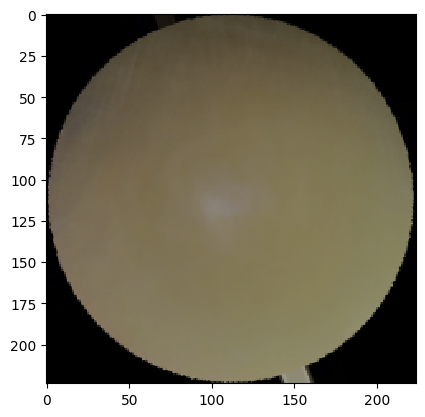

In [77]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()
#images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

## Ejemplos de imágenes aumentadas

Hagamos una cuadrícula de imágenes aumentadas con datos

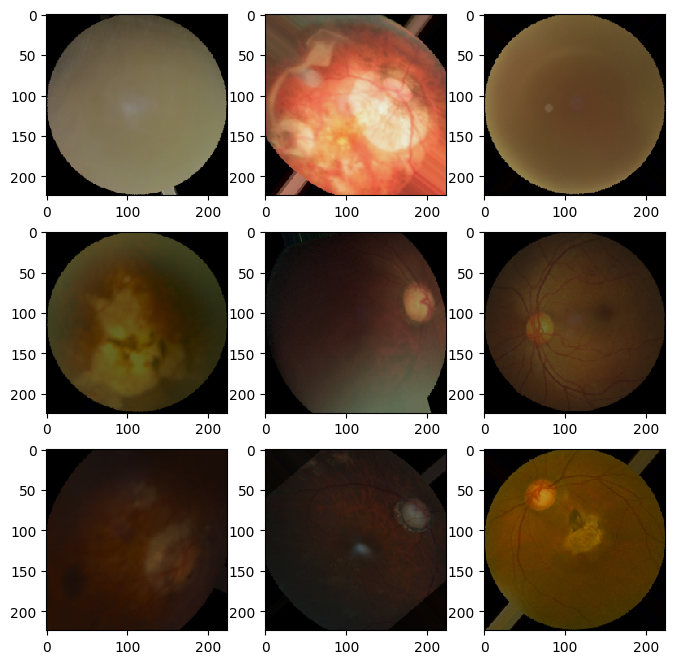

In [78]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

## Diagrama del modelo VGG16

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

https://neurohive.io/en/popular-networks/vgg16/

## Construir nuestro modelo de aprendizaje por transferencia

Aqui cargamos el modelo vgg16, pero como estamos haciendo aprendizaje de transferencia, no queremos la porcion completamente conectada, asi que la arrancaremos con la opcion include_top FALSE.  No queremos esto porque tenemos un conjunto de datos personalizado que tiene un número personalizado de salidas, 7 en este caso. 

Utilizaremos los pesos 'imagenet' ya que esos filtros / pesos / kernels nos ayudarán a encontrar bordes, esquinas, áreas redondeadas de nuestras imágenes.  Estos ya están incorporados y podemos acelerar el proceso utilizando algunos que han demostrado su eficacia en miles de imágenes.

Eliminaremos el 50% de los perceptrones durante la capa final para evitar el sobreajuste.

También utilizaremos el optimizador de descenso de gradiente ADAM.

In [79]:
# obtener el modelo base VGG16
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# añadir nuevas capas densas en la parte superior
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

# Cambiar el número de neuronas en la capa de salida a 7
predictions = keras.layers.Dense(7, activation='softmax')(x)

# definir y compilar el modelo
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False

# Cambiar la función de pérdida a 'categorical_crossentropy'
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


58889256/58889256 [==============================] - 1s 0us/step


## Crear punto de control y parada anticipada

Un punto de control nos permite monitorizar la acuracidad y realizar alguna tarea, en este caso guardaremos el modelo como un fichero.

La parada temprana monitorizará la precisión para un parámetro 'paciencia' y si no hay mejora se detendrá.

In [80]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')


El parámetro steps_per_epoch es el número de lotes de muestras que se necesitan para completar una época. Esto depende del tamaño del lote. El tamaño del lote se establece cuando se inicializan los datos de entrenamiento. Por ejemplo, si estás haciendo esto con ImageDataGenerator.flow() o ImageDataGenerator.flow_from_directory(), el tamaño del lote se especifica con el parámetro batch_size en cada uno de ellos.

Con 3000 muestras por ejemplo:

```
Si el tamaño del lote fuera 100, entonces steps_per_epoch sería 30.
Si el tamaño del lote fuera 10, entonces steps_per_epoch sería 300.
Si el tamaño del lote fuera 1, entonces steps_per_epoch sería 3000.
```

Esto es porque steps_per_epoch debería ser equivalente al número total de muestras dividido por el tamaño del lote. El proceso de implementar esto en Keras está disponible en los dos videos de abajo.

## Constantes para nuestro entrenamiento

SPE es 'pasos por época

n_val_steps es 'número de pasos de validación'

In [81]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

68 17


In [82]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 6.5522 - accuracy: 0.1714 
Epoch 1: val_accuracy improved from -inf to 0.17647, saving model to vgg16_1.h5
68/68 [==============================] - 1916s 28s/step - loss: 6.5522 - accuracy: 0.1714 - val_loss: 3.0281 - val_accuracy: 0.1765
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 2.5893 - accuracy: 0.1510 
Epoch 2: val_accuracy did not improve from 0.17647
68/68 [==============================] - 1868s 27s/step - loss: 2.5893 - accuracy: 0.1510 - val_loss: 2.2841 - val_accuracy: 0.1746
Epoch 3/30
68/68 [==============================] - ETA: 0s - loss: 2.1973 - accuracy: 0.1607 
Epoch 3: val_accuracy did not improve from 0.17647
68/68 [==============================] - 1807s 27s/step - loss: 2.1973 - accuracy: 0.1607 - val_loss: 2.0938 - val_accuracy: 0.1728
Epoch 4/30
68/68 [==============================] - ETA: 0s - loss: 2.0690 - accuracy: 0.1644 
Epoch 4: val_accuracy did not improve from

## Cargar nuestro modelo guardado

In [83]:
from keras.models import load_model
model = load_model('./vgg16_1.h5')

## Graficar la precisión frente a la pérdida

## Que nos dicen las  graficas ?
 Imagina que estás aprendiendo a lanzar una pelota a un objetivo. Cada vez que lanzas, recibes una puntuación que te dice qué tan bien lo hiciste: una puntuación alta si golpeas el objetivo y una puntuación más baja si te alejas. Eso es similar a lo que representamos en estas gráficas.

**Gráfica de Precisión (Accuracy)**: Esta gráfica es como un registro de tus puntuaciones de lanzamiento. Cada vez que lanzas la pelota (que en el aprendizaje de la máquina llamamos una "época"), anotas cuántas veces golpeaste el objetivo. La línea llamada "Accuracy" muestra qué tan bien le fue al modelo en predecir correctamente las categorías de las imágenes durante el entrenamiento. La línea llamada "Validation Accuracy" muestra qué tan bien le fue al modelo en predecir correctamente las categorías de un conjunto de imágenes separado que no usamos para entrenamiento, pero para comprobar su rendimiento. Queremos que ambas líneas sean lo más altas posible, eso significa que nuestro modelo está aprendiendo bien.

**Gráfica de Pérdida (Loss)**: Esta gráfica es como un registro de tus errores de lanzamiento. En lugar de contar las veces que golpeaste el objetivo, cuenta las veces que te perdiste. La línea llamada "loss" muestra cuánto se equivocó el modelo en sus predicciones durante el entrenamiento. La línea llamada "Validation Loss" muestra cuánto se equivocó el modelo en sus predicciones para el conjunto de imágenes de validación. Queremos que estas líneas sean lo más bajas posible, lo que significa que nuestro modelo está haciendo menos errores

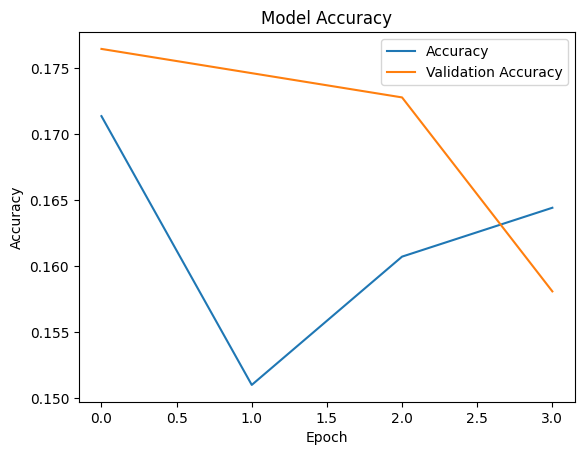

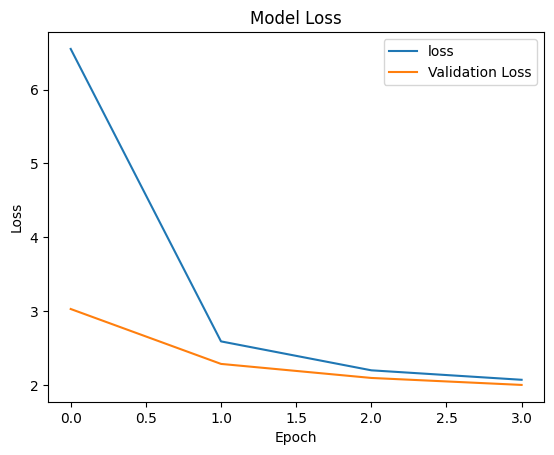

In [85]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

## Hacer nuestras predicciones 
Tenemos varios generadores que alimentan un tamaño de lote establecido de datos de imagen en lo que queramos, siempre que llamemos al iterador del generador. 

Siempre hay que  reiniciar el generador de prueba para que no estemos alimentando ningún dato de imagen antiguo más adelante.

La predicción de salida es sólo un conjunto de etiquetas categóricas de 0 y 1. La predicción de salida NO son datos de imagen.

In [86]:
test_generator.reset()

In [87]:
pred = model.predict(test_generator, verbose=1, steps=test_generator.samples/batch_size)


21/21 [==============================] - 483s 23s/step


**model.predict**: Este es el método que se usa para hacer predicciones con un modelo entrenado en Keras. Toma como entrada los datos para los que quieres generar predicciones.

**test_generator**: Este es el generador de datos que has creado anteriormente. Un generador es un tipo especial de función que produce datos de uno en uno, en lugar de todos a la vez. En este caso, el generador está produciendo las imágenes de prueba una por una.

**steps=test_generator.samples/batch_size**: Este argumento especifica cuántos pasos de predicción se deben hacer. Un paso de predicción implica hacer una predicción para un lote de datos. El número total de pasos es igual al número total de muestras dividido por el tamaño del lote.

Por lo tanto, este código está haciendo predicciones para todas las imágenes de prueba en el test_generator, y luego guarda esas predicciones en la variable pred.

## Datos brutos de predicción

Veamos los resultados del generador de predicciones para comprender mejor la mecánica de los resultados del modelo.

Cada respuesta en esta lista es lo que el modelo piensa que es la imagen correspondiente, basado en lo que ha aprendido durante el entrenamiento.

Cada columna corresponde a una clase diferente. Por ejemplo, si tienes dos clases (digamos "enfermo" y "no enfermo"), la primera columna podría ser la probabilidad de que la imagen sea "enfermo" y la segunda columna la probabilidad de que la imagen sea "no enfermo".

In [88]:
## obtengamos las 10 primeras filas
print(pred[0:10])

[[0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]
 [0.14274532 0.14284675 0.143138   0.14173459 0.14255877 0.14256345
  0.14441308]]


## Convertir datos crudos de predicción

Convirtamos los datos brutos en algo más amigable, 1's y 0's.  ¡Argmax lo hará por nosotros!

In [89]:
predicted_class_idx=np.argmax(pred,axis=1)

## imprimir las mismas 10 filas

print(predicted_class_idx[0:10])

[6 6 6 6 6 6 6 6 6 6]


seguimos trabajando con el conjunto completo de etiquetas de nuestro generador

In [90]:
print(len(predicted_class_idx))

685


## Evaluar la precisión de nuestro modelo

In [91]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

22/22 [==============================] - 488s 22s/step - loss: 3.0284 - accuracy: 0.1766


[3.028430700302124, 0.17664232850074768]

## Convertir etiquetas de una categoría en etiquetas de texto

1's y 0's son geniales, pero eventualmente vamos a necesitar los nombres de texto reales.

Los generadores tienen montones y montones de parámetros para que usted utilice.

In [92]:
valid_generator.class_indices.items()

dict_items([('AMD', 0), ('Miopia patologica', 1), ('Retinopatia Diabetica', 2), ('Retinopatia Hipertensiva', 3), ('cataract', 4), ('glaucoma', 5), ('normal', 6)])

Utiliza las claves de nombre de cadena de las etiquetas de entrenamiento (catarata, galucoma, normal, etc.) y convierte las etiquetas de clase predichas codificadas en un punto en nombres de cadena.  Lo que hacen estas líneas es coger el nombre de la categoría (el valor) y colocarlo en la variable de etiquetas predichas donde cumpla los criterios del valor.

In [93]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [94]:
pred_labels[1:10]

['normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal']

## Construir un nuevo DataFrame

En realidad no necesitamos hacer esto, pero, la construcción de un nuevo mDataFrame puede ser beneficioso si usted necesita hacer cualquier predicción de búsquedas que requieren un DataFrame, o se podría exportar esto a un CSV.  Es muy útil 

In [95]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

Filename Prediction
0   955_right.jpg     normal
1  1868_right.jpg     normal
2  2236_right.jpg     normal
3  1214_right.jpg     normal
4  1469_right.jpg     normal

## Verificar los resultados del DataFrame de predicción

Ya que queremos probar que nuestros datos de prueba están siendo efectivamente probados, verifiquemos que nuestros datos de predicción están efectivamente alineados con el nombre del archivo de prueba, la fila y el diagnóstico.

In [96]:
prediction_df.iloc[35]


Filename      2889_left.jpg
Prediction           normal
Name: 35, dtype: object

Compare esa misma fila con los datos de nuestro generador de pruebas

In [97]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2889_left.jpg
6


## Lista de correctos frente a incorrectos

Ahora que hemos verificado rapidamente que nuestros datos de prueba y predicción están alineados, podemos listar todas nuestras predicciones y compararlas con nuestros datos de prueba.  

Esto es sólo un ejemplo utilizando un pequeño conjunto de datos de prueba (menos de 1000).  No es recomendable hacerlo  para un conjunto de datos grande.

In [98]:
test_file_names=test_generator.filenames  # lista secuencial de nombres de archivos de prueba de cada muestra
test_labels=test_generator.labels # es una lista secuencial de etiquetas de prueba para cada muestra de imagen
class_dict= test_generator.class_indices # un diccionario donde key es el nombre de la clase y value es la etiqueta de la clase

print (class_dict) # consulte el diccionario

new_dict={} 

for key in class_dict: 
    value = class_dict[key]
    new_dict[value] = key

print('  RESULTADO  PREDICCION      CLASE VER      FILENAME ' ) # ajusta el espaciado en función de los nombres de tus clases

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # obtener el índice que tiene la mayor probabilidad
    pred_class=new_dict[pred_index]  # encontrar la clase prevista en función del índice
    true_class=new_dict[test_labels[i]] # utilizar la etiqueta de prueba para obtener la verdadera clase del archivo de prueba
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correcto"
    else:
        result = "Equivocado  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'AMD': 0, 'Miopia patologica': 1, 'Retinopatia Diabetica': 2, 'Retinopatia Hipertensiva': 3, 'cataract': 4, 'glaucoma': 5, 'normal': 6}
  RESULTADO  PREDICCION      CLASE VER      FILENAME 
 Equivocado     normal    cataract      955_right.jpg
 Equivocado     normal    AMD      1868_right.jpg
 Equivocado     normal    cataract      2236_right.jpg
 Equivocado     normal    glaucoma      1214_right.jpg
 Equivocado     normal    glaucoma      1469_right.jpg
 Correcto   normal    normal      3311_left.jpg
 Equivocado     normal    Retinopatia Hipertensiva      45_left.jpg
 Equivocado     normal    AMD      712_left.jpg
 Equivocado     normal    Retinopatia Hipertensiva      826_left.jpg
 Correcto   normal    normal      3414_left.jpg
 Equivocado     normal    AMD      1819_left.jpg
 Equivocado     normal    Retinopatia Diabetica      4631_left.jpg
 Equivocado     normal    glaucoma      1306_left.jpg
 Equivocado     normal    glaucoma      1231_left.jpg
 Correcto   normal    normal      2

## Predicción vs rejilla de imágenes de prueba

Estamos trabajando con imágenes, así que veamos los resultados de nuestra predicción frente a las imágenes de prueba.

Tomemos nuestros elementos de datos de prueba, la matriz de imágenes y la categoría de imágenes codificadas.  Empecemos por cambiarles el nombre a algo más amigable.

In [99]:
test_image_data, test_labels = test_generator.next()

La diferencia de formas de estas matrices.  Las formas deberían darnos una pista y  sentido sobre los datos que contienen.  

La forma de los datos de la imagen estructurada de esta manera:

( NÚMERO DE FILAS, DIMENSIÓN, DIMENSIÓN, PROFUNDIDAD)

Descompongamos la forma:

- En el caso de las imágenes está bastante claro, tenemos 32 muestras recogidas por nuestro generador de pruebas
- 224 en la dimensión horizontal de la imagen
- 224 en la dimensión vertical de la imagen
- 3 de profundidad, ya que se trata de una imagen en color

Mientras que los datos de las etiquetas están estructurados así

- 32 muestras
- 2 de profundidad ya que tenemos 2 salidas, la probabilidad numérica de cada una de nuestras categorías

In [100]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 7)


En nuestra cuadrícula nos gustaría ver algunos parámetros como nombre de archivo, etiqueta y valor categórico (1, 0).

Probemos la salida de esos parámetros desde los generadores

In [101]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

955_right.jpg
4


'normal'

z = 0
#nombre_archivo_prueba

nombre_archivo_prueba=nombre_archivo_prueba[z]
print(nombres_archivo_prueba)

prueba_etiquetas_ejemplo=prueba_generador.etiquetas[z]
print(etiquetas_prueba_ejemplo)

pred_etiquetas[z]

In [102]:
test_labels[5]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

Convierte nuestras tuplas de etiquetas de prueba en un único array unidimensional con argmax.

Está claro que el array completo de etiquetas de prueba tiene sólo 32 elementos, ya que éste es el límite de tamaño de lote que se estableció en los parámetros del generador.

In [103]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([4, 0, 4, 5, 5, 6, 3, 0, 3, 6, 0, 2, 5, 5, 6, 0, 1, 4, 1, 4, 6, 2,
       0, 4, 5, 1, 0, 5, 3, 0, 3, 6])

## Trazar nuestra cuadrícula de comparación

El generador de datos codificó nuestras categorías por nosotros, por lo que catarata = 0 y normal = 1.  Como estamos utilizando generadores de imágenes, sólo podremos reunir 32 imágenes a la vez, ya que éste es el tamaño de lote que hemos establecido.  Si aumentamos el tamaño del lote, el generador recogerá más imágenes y las enviará a través de la función de ajuste durante el entrenamiento.

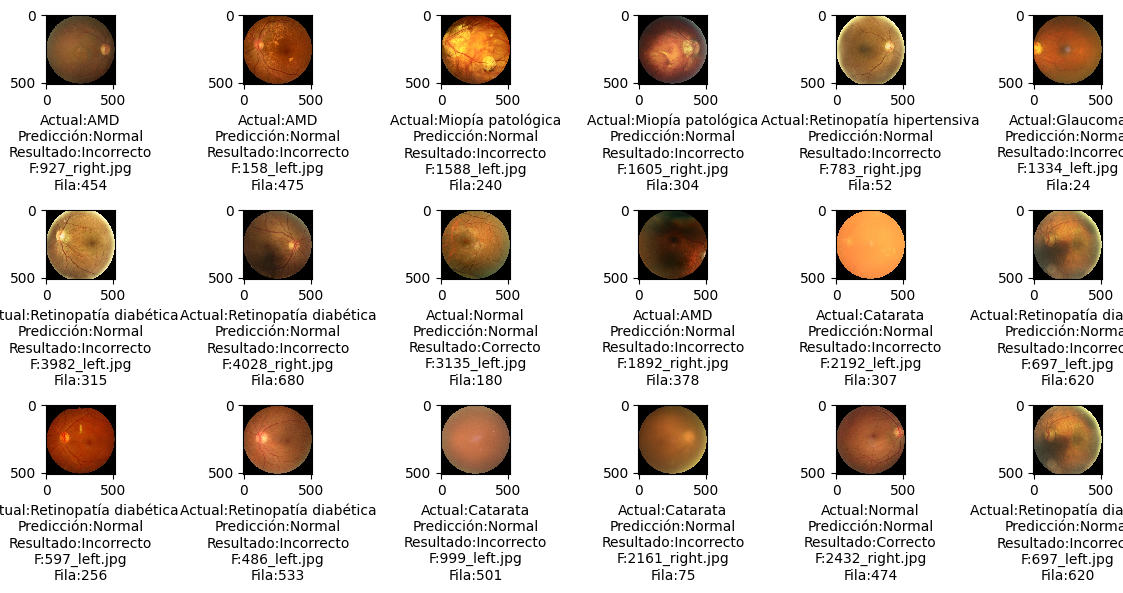

In [110]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

    if category == 0:
        label = 'AMD'
    elif category == 1:
        label = 'Miopía patológica'
    elif category == 2:
        label = 'Retinopatía diabética'
    elif category == 3:
        label = 'Retinopatía hipertensiva'
    elif category == 4:
        label = 'Catarata'
    elif category == 5:
        label = 'Glaucoma'
    elif category == 6:
        label = 'Normal'

    if pred_category == 0:
        pred_label = 'AMD'
    elif pred_category == 1:
        pred_label = 'Miopía patológica'
    elif pred_category == 2:
        pred_label = 'Retinopatía diabética'
    elif pred_category == 3:
        pred_label = 'Retinopatía hipertensiva'
    elif pred_category == 4:
        pred_label = 'Catarata'
    elif pred_category == 5:
        pred_label = 'Glaucoma'
    elif pred_category == 6:
        pred_label = 'Normal'

    if label == pred_label:
        result = "Correcto"
    else:
        result = "Incorrecto"

    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPredicción:{}\nResultado:{}\nF:{}\nFila:{}".format(label,
                                                                              pred_label,
                                                                              result,
                                                                              test_generator.filenames[sample],
                                                                              sample))
plt.tight_layout()


## Reporte de clasificación

In [112]:
print('Classification Report')
target_names = ['AMD', 'Miopia patologica', 'Retinopatia Diabetica', 'Retinopatia Hipertensiva', 'Cataract', 'Glaucoma', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))


Classification Report
                          precision    recall  f1-score   support

                     AMD       0.00      0.00      0.00        97
       Miopia patologica       0.00      0.00      0.00        80
   Retinopatia Diabetica       0.50      0.01      0.02       120
Retinopatia Hipertensiva       0.00      0.00      0.00        55
                Cataract       0.00      0.00      0.00       118
                Glaucoma       0.00      0.00      0.00        95
                  Normal       0.18      1.00      0.30       120

                accuracy                           0.18       685
               macro avg       0.10      0.14      0.05       685
            weighted avg       0.12      0.18      0.06       685



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Matriz de confusión

Una matriz de confusión es una FORMA EXTREMADAMENTE ÚTIL de mostrar la cantidad de predicciones correctas frente a las incorrectas.  Pero la matriz de confusión en bruto es una matriz bastante básica.  Esto se puede trazar para que sea mucho más fácil de leer.

In [113]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[  0,   0,   0,   0,   0,   0,  97],
       [  0,   0,   1,   0,   0,   0,  79],
       [  0,   0,   1,   0,   0,   0, 119],
       [  0,   0,   0,   0,   0,   0,  55],
       [  0,   0,   0,   0,   0,   0, 118],
       [  0,   0,   0,   0,   0,   0,  95],
       [  0,   0,   0,   0,   0,   0, 120]])

## Graficar matriz de confusión

In [114]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Matriz de confusión',
                        cmap=plt.cm.Blues):
    """
    Esta función imprime y traza la matriz de confusión.
    Se puede aplicar la normalización configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión, sin normalización')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [115]:
cm_plot_labels = ['AMD', 'Miopia patologica', 'Retinopatia Diabetica', 'Retinopatia Hipertensiva', 'Cataract', 'Glaucoma', 'Normal']


Podemos ver que el eje y son las etiquetas verdaderas (de prueba) y el eje x es la salida predicha.  

Los elementos correctos son aquellos en los que coinciden las celdas verdaderas y las predichas: las categorías son similares, en este caso, un color más oscuro.

Los elementos incorrectos son de color más claro y se encuentran donde las celdas verdaderas y las predichas tienen categorías diferentes.

Matriz de confusión, sin normalización
[[  0   0   0   0   0   0  97]
 [  0   0   1   0   0   0  79]
 [  0   0   1   0   0   0 119]
 [  0   0   0   0   0   0  55]
 [  0   0   0   0   0   0 118]
 [  0   0   0   0   0   0  95]
 [  0   0   0   0   0   0 120]]


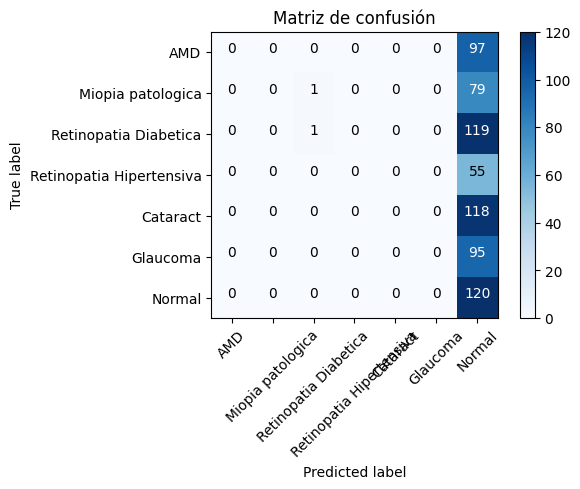

In [117]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Matriz de confusión')